In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import warnings
import io
import math
warnings.filterwarnings("ignore")

In [12]:
def moving_average(a, n=10): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret/=n
    # Masking
    ret[:n-1]=ret[n-1]
    ret=ret.reshape(-1,1)
    return ret

def read_train_patients(input_len = 8, output_len = 6):
    x_train=[]
    y_train=[]
    for i in range(1, 15):
        df=pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
        dataset=df.values
        dataset = moving_average(dataset)

        scaler = MinMaxScaler(feature_range=(0, 1)) 
        scaled_data = scaler.fit_transform(dataset)
        train_data = scaled_data
        
        for i in range(input_len,len(train_data)-output_len):
            x_train.append(train_data[i-input_len:i,0])
            y_train.append(train_data[i+output_len-1,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape 
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    print(y_train)
    return scaler, x_train, y_train
    #return x_train, y_train

In [13]:
class CustomHistory(Callback):
        def init(self):
            self.train_loss = []
            self.val_loss = []
        
        def on_epoch_end(self, batch, logs={}):
            self.train_loss.append(logs.get('loss'))
            self.val_loss.append(logs.get('val_loss'))
            
def train_model(x_train, y_train, batch_size=1, epochs=1):
    
    X_val = x_train[11000:]
    Y_val = y_train[11000:]
    X_train = x_train[:11000]
    Y_train = y_train[:11000]

    # 라벨링 전환?????????
    #Y_train = np_utils.to_categorical(Y_train)
    #Y_val = np_utils.to_categorical(Y_val)
    
    print(Y_train)
    print(Y_val)
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], 1)))
    #model.add(LSTM(50))
    model.add(Dropout(0.3))
    model.add(Dense(8))
    model.add(Dense(8))
    model.add(Dense(1))
    print(model.summary())

    
    #model.add(LSTM(50))
    
    
    model.compile(optimizer='adam', loss='mse')

    #over fitting 방지
    early_stopping = EarlyStopping(monitor='loss', patience=50, mode='auto')

    custom_hist = CustomHistory()
    custom_hist.init()
   
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=[custom_hist],validation_data=(X_val, Y_val))
    #hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
    
    # 상태유지 LSTM fit
    #for i in range(epochs):
    #    model.fit(X_train, Y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(X_val,Y_val))
    #    model.reset_states()
    
    # 5. 학습과정 살펴보기
    """plt.figure(figsize=(24,16))
    plt.plot(custom_hist.train_loss, linewidth=5)
    plt.plot(custom_hist.val_loss, linewidth=5)
    plt.ylim(0, 0.0300)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0025))
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel('loss',fontsize=24)
    plt.xlabel('epoch',fontsize=24)
    plt.legend(['train', 'val'], loc='upper right',fontsize=24)
    plt.show()"""

    
    return model, custom_hist

In [14]:
scaler, x_train, y_train = read_train_patients()

[0.13790036 0.14546263 0.15435943 ... 0.77902622 0.78127341 0.77902622]


In [15]:
model, custom_hist = train_model(x_train, y_train, batch_size=32, epochs=500) 

[0.13790036 0.14546263 0.15435943 ... 0.20022124 0.19247788 0.1880531 ]
[0.19026549 0.20243363 0.22566372 0.25995575 0.30199115 0.35066372
 0.40376106 0.46128319 0.5210177  0.57964602 0.63495575 0.68030973
 0.71460177 0.73451327 0.74336283 0.74115044 0.7289823  0.7090708
 0.68362832 0.65707965 0.62942478 0.60287611 0.57743363 0.55752212
 0.54424779 0.53982301 0.54314159 0.54867257 0.55309735 0.55309735
 0.54756637 0.53871681 0.52876106 0.51880531 0.50774336 0.49446903
 0.4789823  0.46349558 0.45022124 0.44137168 0.4380531  0.44026549
 0.44579646 0.45353982 0.46017699 0.46460177 0.46681416 0.46681416
 0.46570796 0.46017699 0.25018727 0.25093633 0.25168539 0.25393258
 0.25692884 0.25992509 0.26217228 0.26292135 0.26067416 0.25543071
 0.2494382  0.24269663 0.23595506 0.22921348 0.2247191  0.22247191
 0.22172285 0.22247191 0.22546816 0.23220974 0.24269663 0.25842697
 0.27715356 0.29812734 0.31685393 0.33333333 0.34681648 0.35730337
 0.36554307 0.37153558 0.3752809  0.37602996 0.37602996 0.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 408       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 10,889
Trainable params: 10,889
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
344/344 [==============================] - 16s 29ms/step - loss: 0.0462 - val_loss: 0.0091
Epoch 2/

344/344 [==============================] - 8s 24ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 150/500
344/344 [==============================] - 8s 22ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 151/500
344/344 [==============================] - 7s 22ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 152/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 153/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 154/500
344/344 [==============================] - 7s 22ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 155/500
344/344 [==============================] - 8s 22ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 156/500
344/344 [==============================] - 7s 22ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 157/500
344/344 [==============================] - 7s 21ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 158/500
344/344 [==============================] - 8s 22ms/step - loss: 

Epoch 228/500
344/344 [==============================] - 8s 24ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 229/500
344/344 [==============================] - 9s 25ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 230/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 231/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 232/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 233/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 234/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 235/500
344/344 [==============================] - 7s 21ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 236/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 237/500
344/344 [==============================] - 9s 25ms

Epoch 385/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 386/500
344/344 [==============================] - 8s 22ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 387/500
344/344 [==============================] - 8s 22ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 388/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 389/500
344/344 [==============================] - 8s 23ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 390/500
344/344 [==============================] - 7s 21ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 391/500
344/344 [==============================] - 8s 22ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 392/500
344/344 [==============================] - 8s 22ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 393/500
344/344 [==============================] - 9s 27ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 394/500
344/344 [==============================] - 8s 24ms

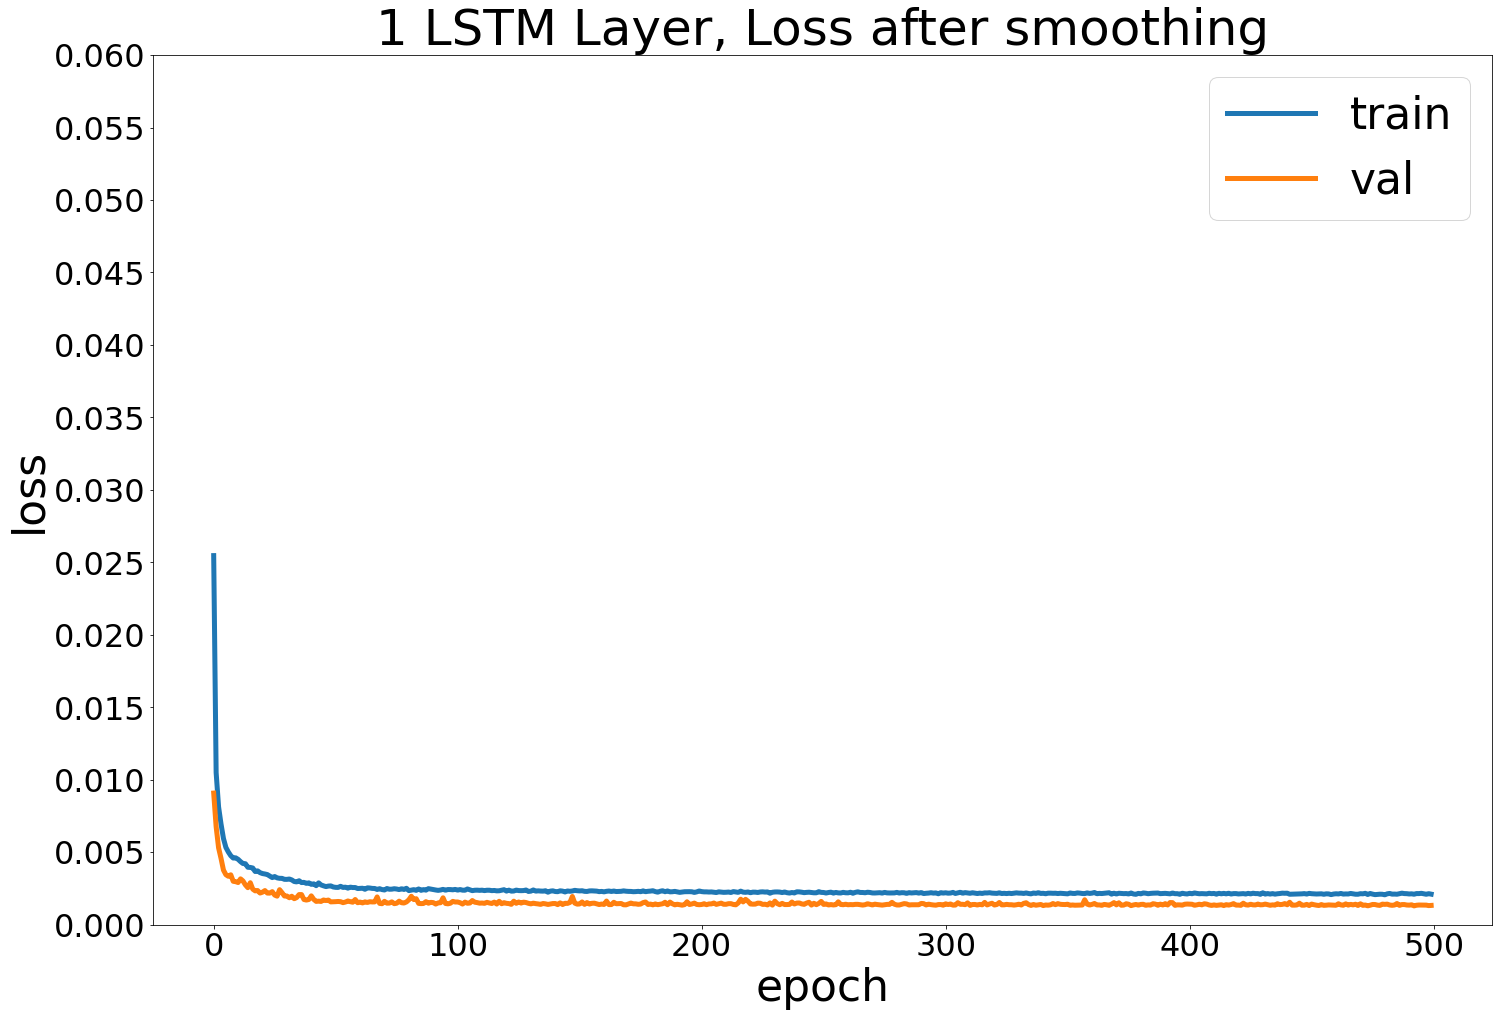

In [21]:
def plot_loss(hist):
    plt.figure(figsize=(24,16))
    plt.title('1 LSTM Layer, Loss after smoothing',fontsize=50)
    plt.plot(custom_hist.train_loss, linewidth=5)
    plt.plot(custom_hist.val_loss, linewidth=5)
    plt.ylim(0, 0.0600)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    plt.ylabel('loss',fontsize=44)
    plt.xlabel('epoch',fontsize=44)
    plt.legend(['train', 'val'], loc='upper right',fontsize=44)
    plt.show()

plot_loss(custom_hist)

In [17]:
def show_plots(i, continuous_ytest, continuous_predictions):
    plt.figure(figsize=(24,16))
    plt.title('Blood Glucose Prediction Model Result_patient_{}'.format(i),fontsize=40)
    plt.plot(continuous_ytest, color = 'b', linewidth=3)
    plt.plot(continuous_predictions, color = 'r', ls="--", linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.ylim(40, 260)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.xlabel('Timestamp',fontsize=28)
    plt.ylabel('BG(CGM) (mg/dL)',fontsize=28)
    plt.legend(['Real','Predictions'], loc='upper right',fontsize=32)
    plt.show()

In [18]:
def test_model(model, i, input_len=8, output_len=6):
    df = pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
    dataset=df.values
    
    dataset = moving_average(dataset)
    
    # Scalling data from 0 - 1 to input in the neural network
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset)
    
    x_test =[]
    y_test =[]
    
    continuous_ytest=[]
    i= input_len
    
    for i in range(input_len,len(dataset)-output_len):
        x_test.append(scaled_data[i-input_len:i,0])
        y_test.append(dataset[i+output_len-1,0])
        continuous_ytest.append(dataset[i+output_len-1,0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    #y_test = np.reshape(y_test,(-1,1))
    #print("x_test: ", x_test)
    x_test= np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    predictions = model.predict(x_test)
    predictions = np.reshape(predictions,(1,-1))
    predictions = scaler.inverse_transform(predictions)
    print(predictions)
    print(y_test)
    #print("predictions: ", predictions)
    
    continuous_predictions = predictions[0]
    for i in range(1, len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions, predictions[i]])
    
    #print(predictions)
    #print(y_test)
    
    
    rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
    mape=np.mean(np.abs((predictions-y_test)/y_test)*100)
    #print("prediction:", np.shape(pred))
    #print("y_test:",np.shape(y_test))
    #print(len(continuous_ytest))
    #print("continuouse_ytest: ", continuous_ytest)
    #print("continuous_predictions: ", continuous_predictions)
    return rmse, mape, continuous_ytest, continuous_predictions

[[102.31983  102.31983  102.31983   86.71291  107.014275 109.62538
  108.005424 109.86571  110.29993  109.65608  111.40618  113.334
  111.366196 112.48015  111.579025 109.900734 107.8539   110.65476
  109.309784 111.18253  108.81159  107.29652  108.82301  103.848595
  102.4264   105.22898  110.963394 111.51918  119.090904 120.64898
  125.97259  131.97437  129.64838  135.0927   137.93446  135.7077
  131.76852  130.99416  129.93523  129.53458  128.18536  130.067
  133.07204  127.28195  127.020676 122.22436  125.15405  126.024574
  126.312515 125.09567  122.15282  117.870224 112.071045 112.74295
  108.75438  114.56548  112.49185  108.91195  105.520164 100.011665
   97.15132   93.99501   95.81136   94.61667  100.82447  101.9333
  104.39938  106.81662  103.78473  109.46097  111.50385  113.17079
  112.9308   117.20892  118.0992   122.613815 118.15045  115.87162
  120.75678  121.3819   123.39589  126.033356 127.95237  129.13312
  127.30543  126.7459   128.88438  134.03487  131.23015  129.4880

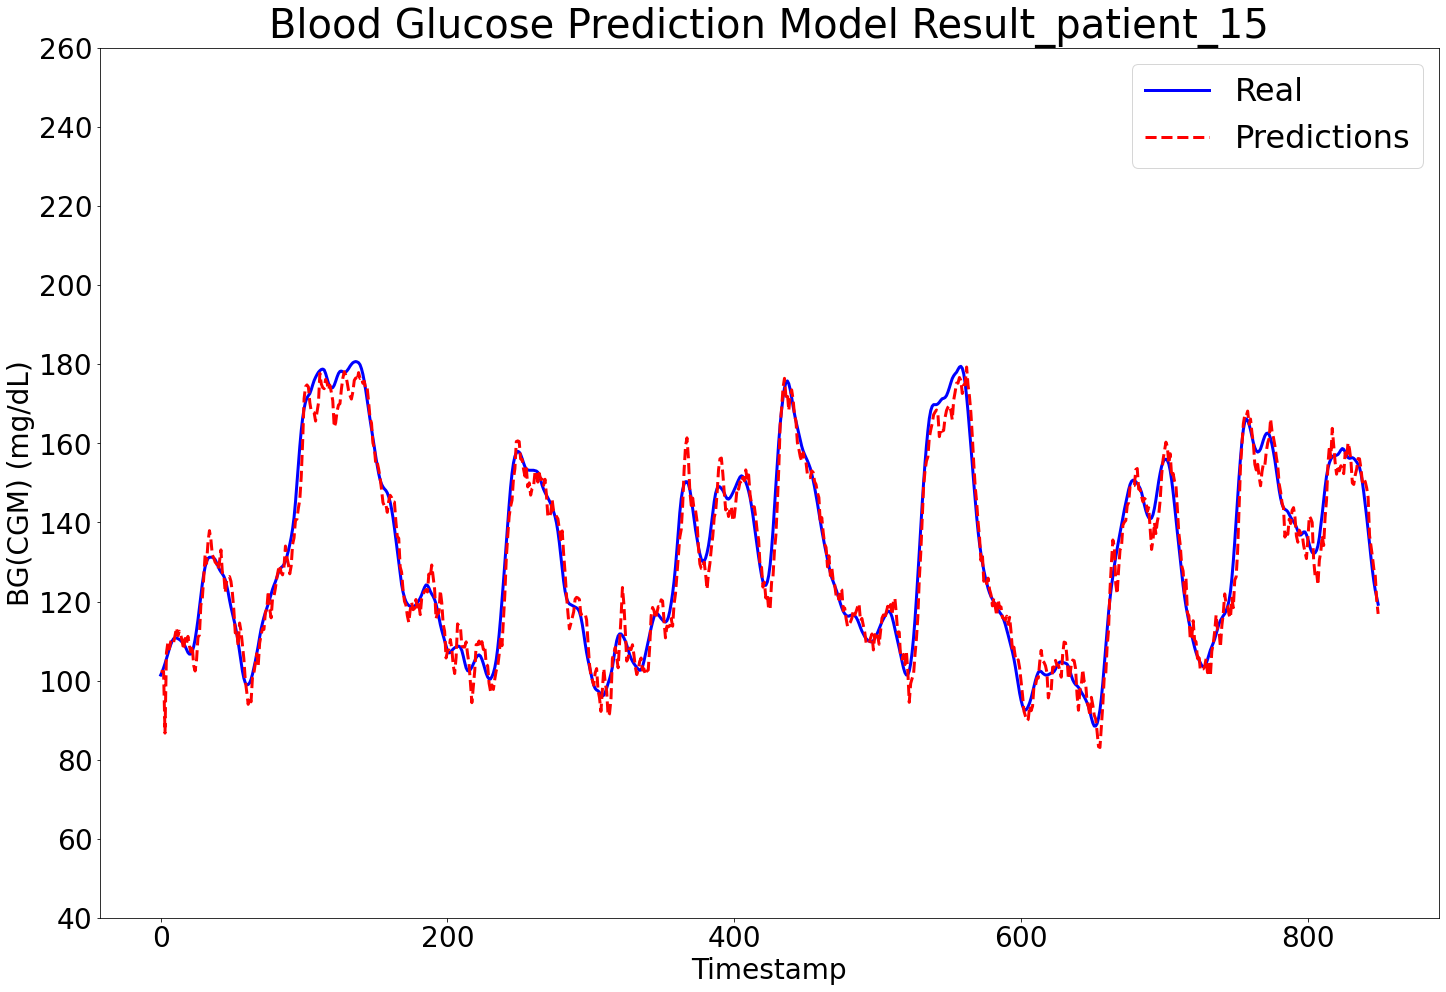

0.9894331238667329
Time_delay(min):  5
Root-Mean-Squared Deviation 4.4034744105251615
Mean-Absolute-Percentage-Error 2.6568619808654934
[[129.88972  129.88972  129.88972  133.70735  120.79044  124.688614
  120.22551  116.08953  111.56041  111.88245  107.1286   106.47474
  102.98495  107.00466  108.88445  106.041794 107.49076  109.170784
  108.17747  111.90374  116.40176  120.97447  127.33748  129.32785
  128.8486   129.1051   127.81295  123.647224 129.37798  131.50317
  132.99712  135.7191   135.5151   137.99835  136.72777  131.7083
  128.21709  133.61252  132.1028   127.11282  125.57495  117.63377
  117.09046  107.808304 109.95215  112.2511   116.54326  115.55341
  117.44237  118.7355   120.80124  125.33973  125.09606  126.9582
  123.26138  122.65235  123.328545 120.72621  120.30546  127.242905
  130.20564  127.334984 124.39765  123.03859  122.96239  128.68149
  128.62633  132.25177  133.22812  129.20067  122.61107  123.56421
  122.56301  125.550545 128.50414  123.094666 121.84932  12

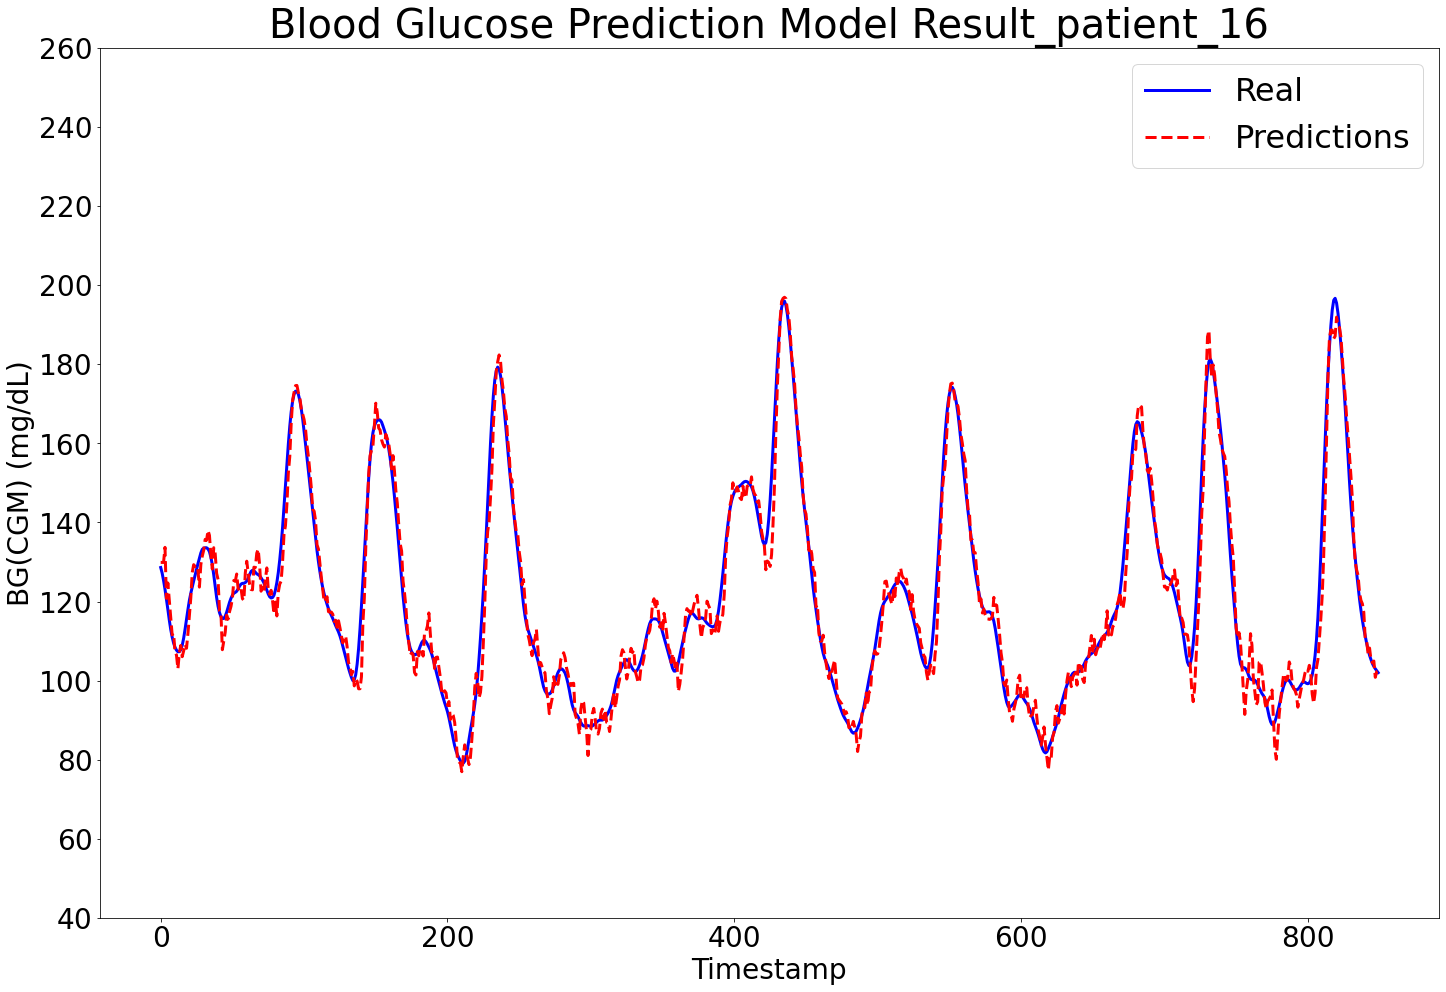

0.9915509091489645
Time_delay(min):  5
Root-Mean-Squared Deviation 4.701532313337598
Mean-Absolute-Percentage-Error 2.8566183575168007
[[114.34758  114.34758  114.34758  102.843666 115.848045 112.118065
  107.2811   108.99969  107.09596  105.426605 104.33482  106.77007
  107.93337  105.73382  105.889595 108.00701  108.38969  109.3267
  108.82519  107.762856 110.2163   111.17094  108.24304  110.52662
  113.05257  113.7315   116.87423  116.794754 116.18024  115.46579
  114.08341  110.20178  111.16363  109.9235   109.73445  108.13515
  105.870415 105.6776   105.47215  105.63014  104.76716  107.9338
  104.669304 106.254585 103.549095 102.992836 103.16998  104.88781
  103.26121  101.26226   96.8197    91.17824   96.24638  100.3505
  109.2272   111.92629  113.43075  111.529755 114.14985  117.295265
  126.80807  128.70198  125.85416  118.89955  113.5432   116.71173
  121.60118  124.40626  122.04206  119.73819  116.50039  117.36866
  117.00473  118.698    118.73485  114.722755 114.5612   113.5

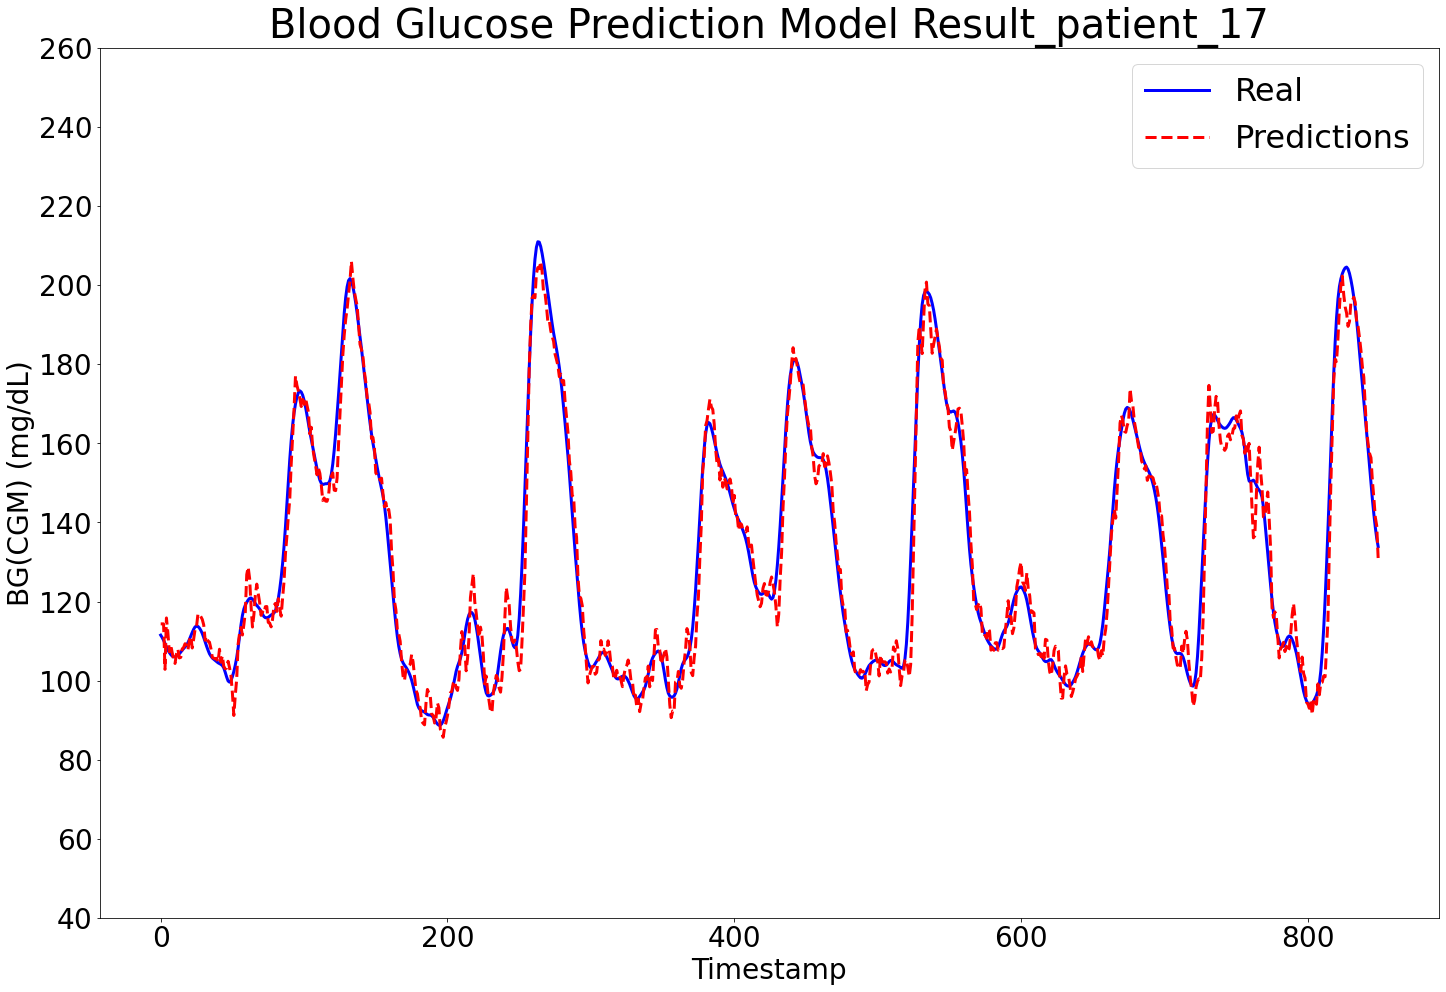

0.9908179427351876
Time_delay(min):  5
Root-Mean-Squared Deviation 5.384328894213189
Mean-Absolute-Percentage-Error 2.938161069086553
[[144.08539  144.08539  144.08539  144.08539  132.66788  133.631
  133.43266  136.06996  131.91145  133.6056   131.36964  129.80247
  126.694885 125.144264 121.43782  117.2138   118.41518  115.28731
  117.94794  116.842514 117.26722  115.91628  115.558655 118.10162
  122.43035  124.47768  125.54967  125.247475 121.74329  122.49264
  119.279076 122.21002  122.39988  125.03057  120.224396 121.11363
  119.42284  119.02128  124.36801  124.16846  126.89957  123.95391
  118.63983  114.599815 115.658775 112.944756 113.62602  118.141624
  114.91617  110.86484  110.85893  107.17014  110.331924 113.451355
  112.89008  114.33532  115.97278  111.651436 112.08015  118.53054
  123.66931  126.84874  127.48304  125.36514  123.50646  126.34395
  123.59445  125.70442  128.17929  123.79821  119.22023  119.31033
  116.04726  114.33373  113.931885 105.30818  111.5008   115.0

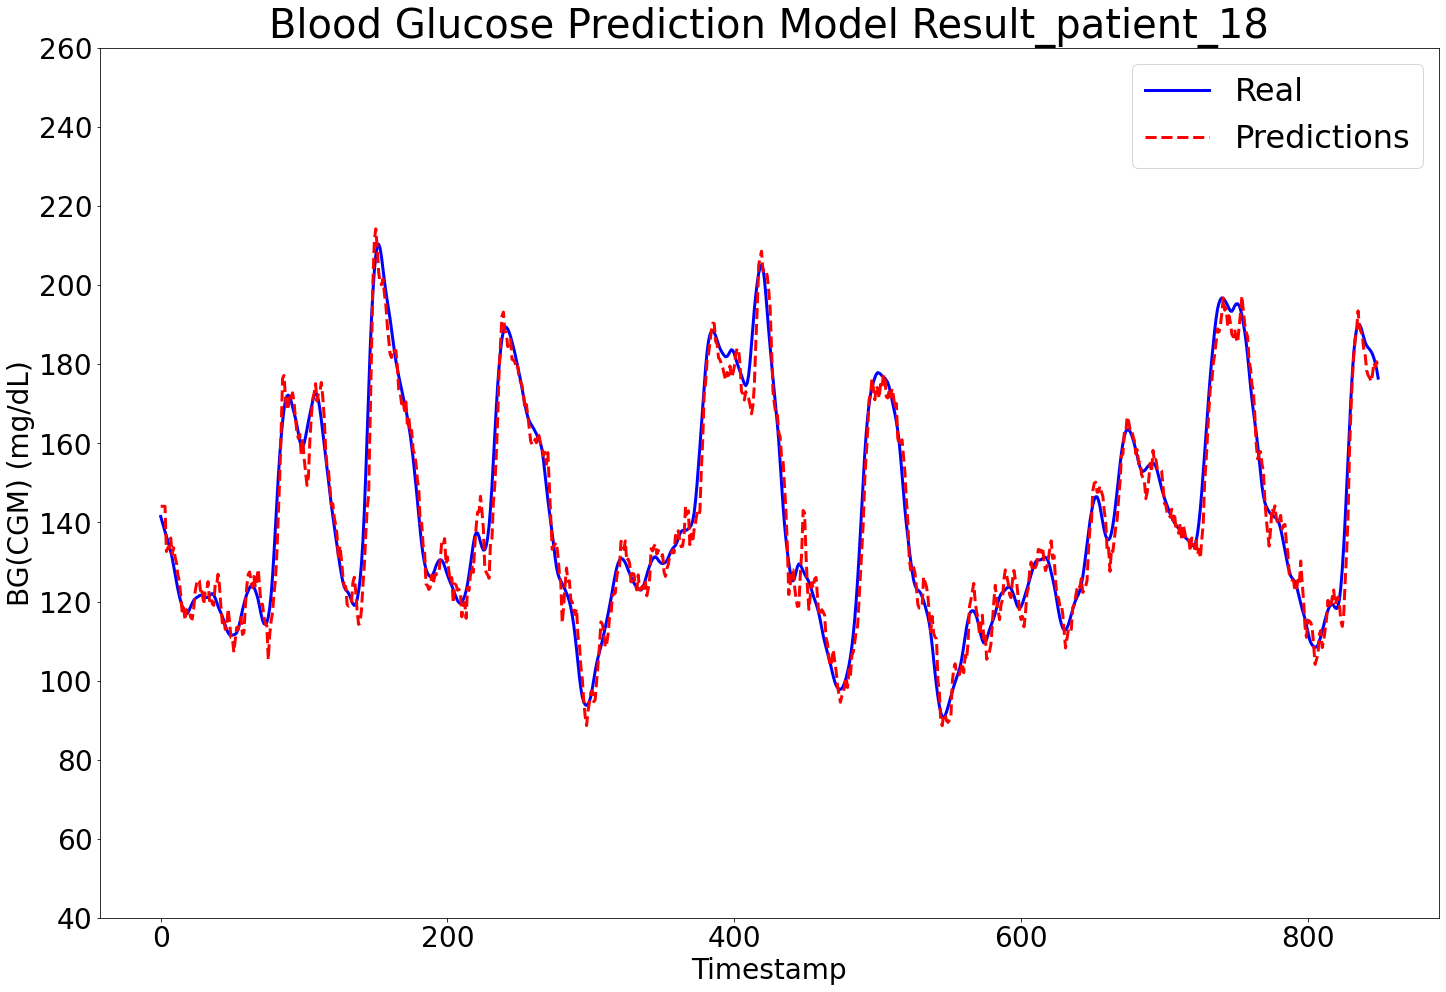

0.9892387722329807
Time_delay(min):  5
Root-Mean-Squared Deviation 5.145003636895735
Mean-Absolute-Percentage-Error 2.7900321420996024
[[108.425804 108.425804 108.425804 118.024734 108.02254  109.368454
  110.75094  102.90439  105.68183  108.43851  108.18479  106.57547
  101.394615 104.05727  105.753624 105.92987  108.77145  112.416855
  114.25957  116.959816 114.563545 115.029366 120.450554 119.87071
  116.446014 118.64075  114.670784 113.229355 111.974266 113.50361
  117.03487  119.84861  117.122246 117.19855  119.67732  117.32108
  121.57808  122.82955  126.29555  125.08387  129.29657  132.98822
  139.03152  137.67686  138.81943  136.19666  133.14723  135.94879
  132.65897  135.61275  131.20094  130.27556  128.08362  135.8055
  138.67267  140.20964  139.40762  134.08719  132.81627  130.16068
  130.84111  130.37737  130.92284  124.78143  122.25198  121.07283
  122.36104  122.84528  127.423294 126.434    127.155426 123.86357
  120.97567  120.0576   117.99604  118.002205 116.42302  116

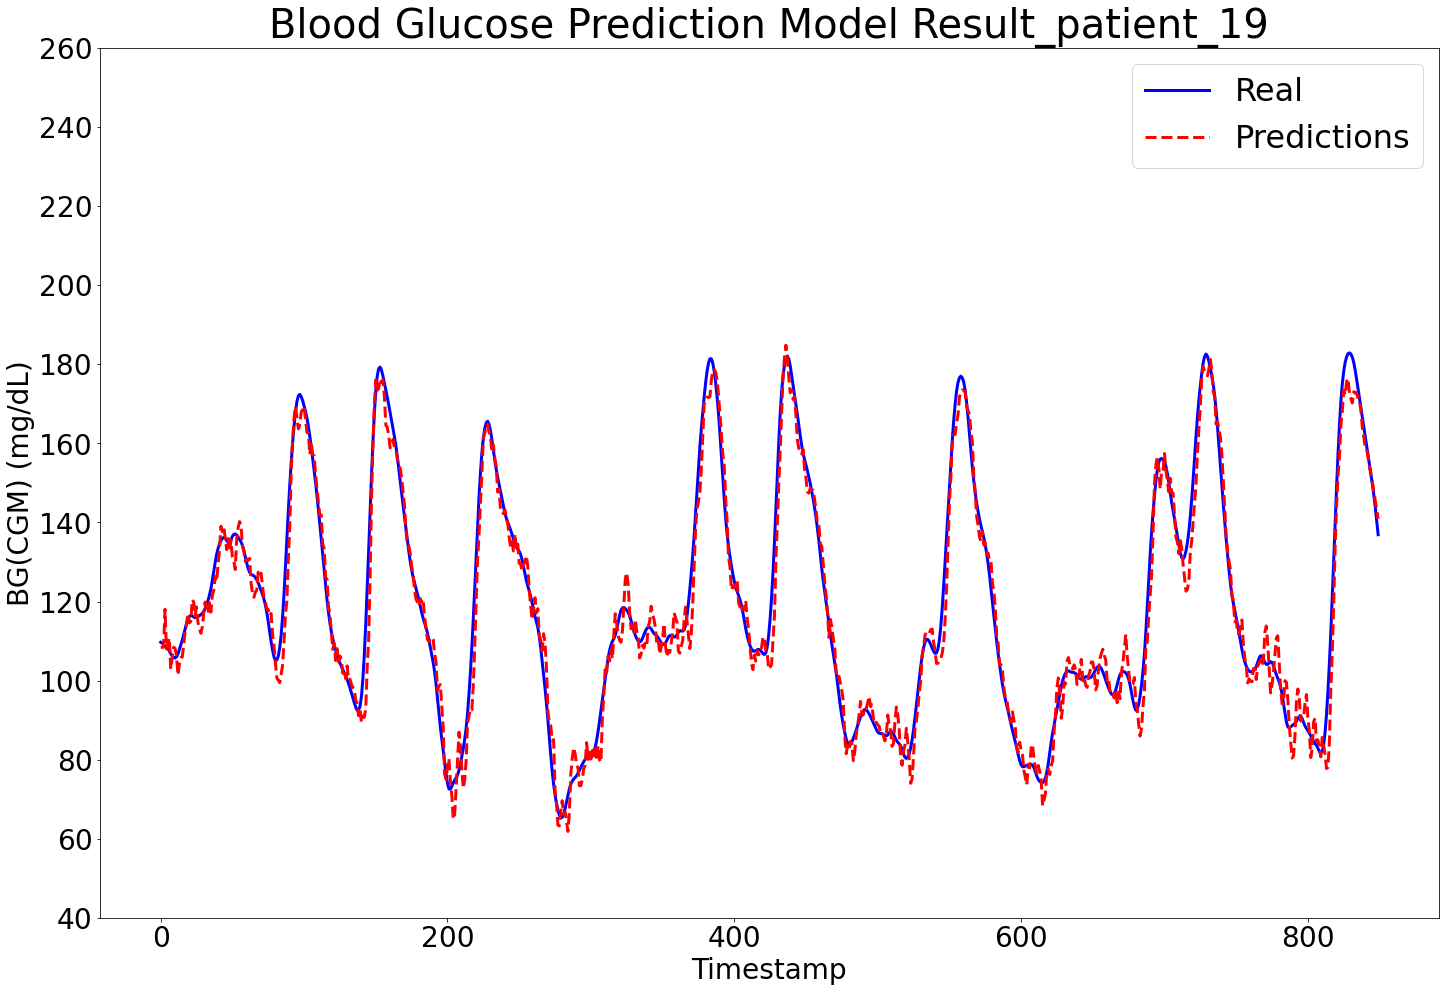

0.9910255292667352
Time_delay(min):  5
Root-Mean-Squared Deviation 5.3149969097150604
Mean-Absolute-Percentage-Error 3.445976547861855
[[124.91397  124.91397  124.91397  108.675385 127.88128  127.300255
  129.01341  132.83542  132.20415  124.39655  128.59695  125.94185
  130.14343  126.78699  122.668465 116.89281  109.742226 107.57748
  105.860176 110.41449  101.98448  100.8512    99.460526 102.008736
  103.51083  105.33062  103.820366 100.69714  105.72446  107.78044
  112.88701  114.98895  115.65474  113.64718  113.51477  114.03941
  120.12488  125.474174 127.15688  126.37555  125.87714  126.436424
  128.0185   126.789986 126.26721  122.92898  121.55451  120.51091
  115.58966  116.596504 114.86211  111.7832   105.91349  103.23378
   96.89454  101.36362  101.712234 104.35632  107.06034  104.01998
  105.119705 106.84849  107.5893   113.13649  118.05974  112.76031
  110.84802  106.09186  104.06434  107.29673  107.082405 104.39411
  104.30327  104.4927   104.075455 106.68304  106.657394 1

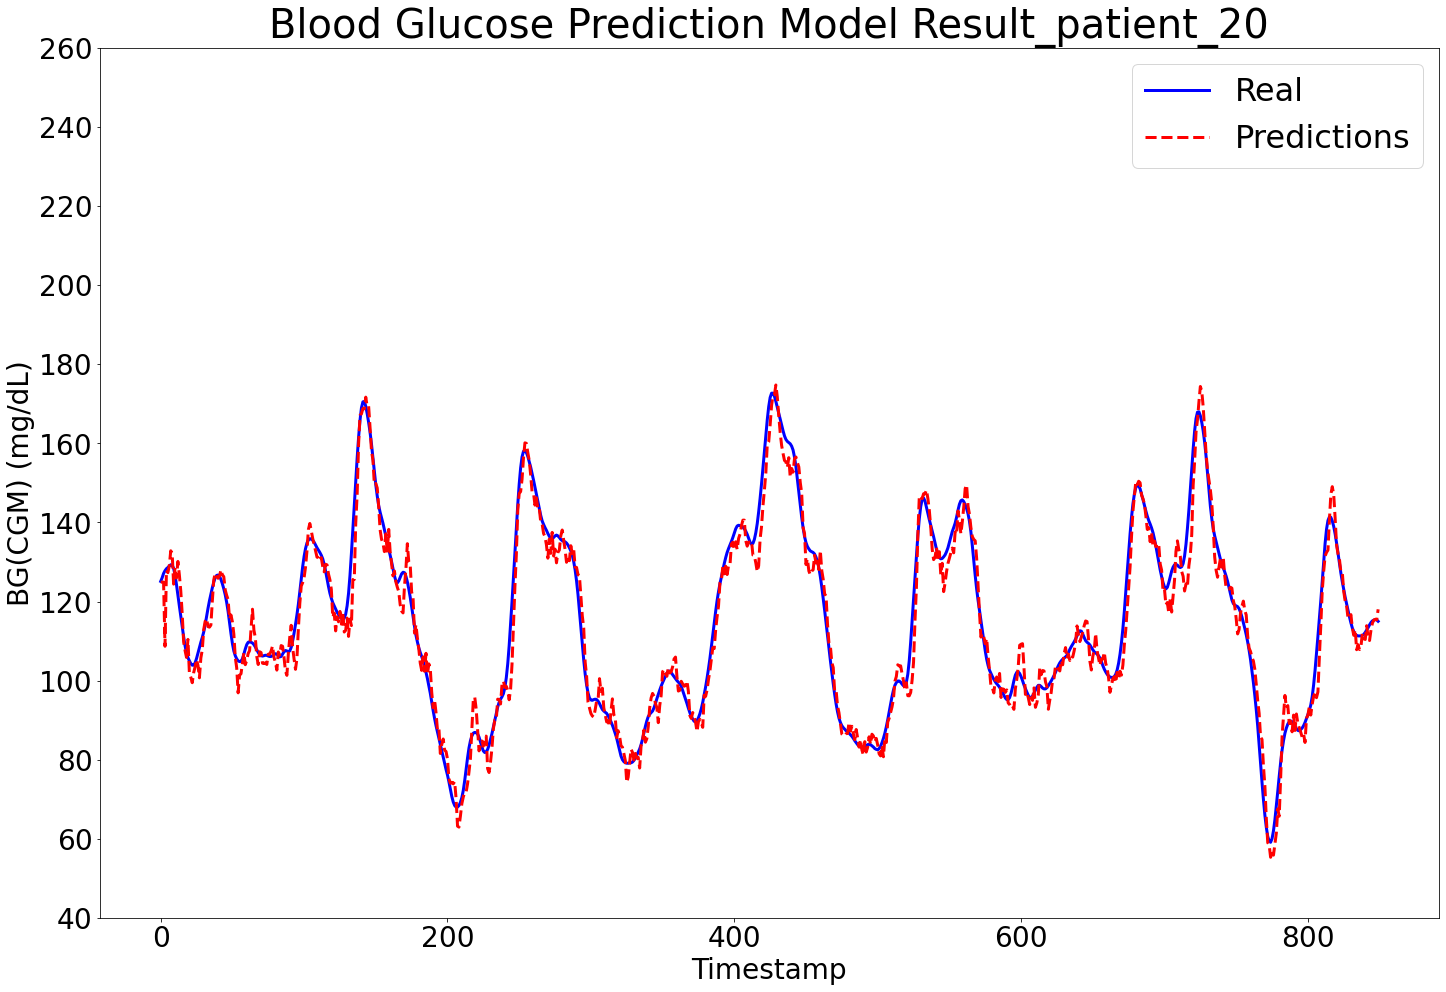

0.9890997101850235
Time_delay(min):  5
Root-Mean-Squared Deviation 4.54815002024806
Mean-Absolute-Percentage-Error 3.0157810237229494


In [19]:
def get_correlation(arr1, arr2):
    cov = np.cov(arr1, arr2)[0, 1]  # 공분산
    arr1sd = np.std(arr1, ddof=1)   # x의 표본표준편차
    arr2sd = np.std(arr2, ddof=1)   # y의 표본표준편차
    return cov / ( arr1sd * arr2sd )

"""def get_time_gain(continuous_ytest, continuous_predictions):
    corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6:-6])[0,1]
    max_corr = corr
    j=1
    while j < 6:
        trans_corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6+j:-6+j])[0,1] 
        if max_corr < trans_corr:
            max_corr = trans_corr
            print(max_corr)
            j+=1
            
        else:
            break
    return (j-1)"""

def get_time_gain(continuous_ytest, continuous_predictions):
    corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6:-6])[0,1]
    max_corr = corr
    #j=1
    max_trans = 0
    for j in range(1, 6):
        trans_corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6+j:-6+j])[0,1] 
        if max_corr < trans_corr:
            max_corr = trans_corr
            print(max_corr)
            max_trans = j
    return max_trans
    

for i in range(15,21):
    rmse, mape, continuous_ytest, continuous_predictions = test_model(model, i)
    show_plots(i, continuous_ytest, continuous_predictions)
    time_gain = get_time_gain(continuous_ytest, continuous_predictions)
    print("Time_delay(min): ", time_gain*5)
    print("Root-Mean-Squared Deviation {}".format(rmse))
    print("Mean-Absolute-Percentage-Error {}".format(mape))

In [20]:
model.save('LSTM_diabetes_model_1layers.h5')